In [2]:
# NOTE: this is a custom cell that contains the common imports I personally 
# use these may/may not be necessary for the following examples

# DL framework
import tensorflow as tf

from datetime import datetime

# common packages
import numpy as np
import os # handling file i/o
import sys
import math
import time # timing epochs
import random

# for ordered dict when building layer components
import collections

# plotting pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib import colors # making colors consistent
from mpl_toolkits.axes_grid1 import make_axes_locatable # colorbar helper


# from imageio import imread # read image from disk
# + data augmentation
from scipy import ndimage
from scipy import misc


import pickle # manually saving best params
from sklearn.utils import shuffle # shuffling data batches
from tqdm import tqdm # display training progress bar

# const
SEED = 42

# Helper to make the output consistent
def reset_graph(seed=SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# helper to create dirs if they don't already exist
def maybe_create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print("{} created".format(dir_path))
    else:
        print("{} already exists".format(dir_path))
    
def make_standard_dirs(saver=True, best_params=True, tf_logs=True):
    # `saver/` will hold tf saver files
    maybe_create_dir("lesion/saver")
    # `best_params/` will hold a serialized version of the best params
    # I like to keep this as a backup in case I run into issues with
    # the saver files
    maybe_create_dir("lesion/best_params")
    # `tf_logs/` will hold the logs that will be visable in tensorboard
    maybe_create_dir("lesion/tf_logs")

    
# set tf log level to supress messages, unless an error
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Important Version information
print("Python: {}".format(sys.version_info[:]))
print('TensorFlow: {}'.format(tf.__version__))

# Check if using GPU
if not tf.test.gpu_device_name():
    print('No GPU')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    
reset_graph()

Python: (3, 5, 4, 'final', 0)
TensorFlow: 1.4.0
Default GPU Device: /device:GPU:0


In [3]:
make_standard_dirs()

lesion/saver created
lesion/best_params created
lesion/tf_logs created


In [15]:
BEST_PARAMS_PATH = "best_params"
FINAL_DIR = "../../dataset/record_holder/lesion"
for _, _, files in os.walk(FINAL_DIR):
    files = sorted(files)
    for filename in files:
        print(filename)

test.tfrecords
train.tfrecords
val.tfrecords


In [16]:
# these two functions (get_model_params and restore_model_params) are 
# ad[a|o]pted from; 
# https://github.com/ageron/handson-ml/blob/master/11_deep_learning.ipynb
def get_model_params():
    global_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {global_vars.op.name: value for global_vars, value in 
            zip(global_vars, tf.get_default_session().run(global_vars))}

def restore_model_params(model_params, g, sess):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: g.get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    sess.run(assign_ops, feed_dict=feed_dict)

# these two functions are used to manually save the best
# model params to disk
def save_obj(obj, name):
    with open('lesion/best_params/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('lesion/best_params/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Dataset

In [17]:
GLOBAL_SET_TYPE = None

def _parse_function(example_proto):
    global GLOBAL_SET_TYPE
    labelName = str(GLOBAL_SET_TYPE) + '/label'
    featureName = str(GLOBAL_SET_TYPE) + '/image'
    feature = {featureName: tf.FixedLenFeature([], tf.string),
               labelName: tf.FixedLenFeature([], tf.int64)}
    
    # decode
    parsed_features = tf.parse_single_example(example_proto, features=feature)
    
    # convert image data from string to number
    image = tf.decode_raw(parsed_features[featureName], tf.float32)
    image = tf.reshape(image, [224, 224, 3])
    label = tf.cast(parsed_features[labelName], tf.int64)
    
    # [do any preprocessing here]
    
    return image, label

In [59]:
def return_batched_iter(setType, data_params, sess):
    global GLOBAL_SET_TYPE
    global FINAL_DIR
    GLOBAL_SET_TYPE = setType
    
    filenames_ph = tf.placeholder(tf.string, shape=[None])

    dataset = tf.data.TFRecordDataset(filenames_ph)
    dataset = dataset.map(_parse_function)  # Parse the record into tensors.
    dataset = dataset.shuffle(buffer_size=data_params['buffer_size'])
    dataset = dataset.batch(data_params['batch_size'])
    dataset = dataset.repeat(1)
    
    iterator = dataset.make_initializable_iterator()
    
    tfrecords_file_name = str(GLOBAL_SET_TYPE) + '.tfrecords'
    tfrecord_file_path = os.path.join(FINAL_DIR, tfrecords_file_name)
    
    # initialize
    sess.run(iterator.initializer, feed_dict={filenames_ph: [tfrecord_file_path]})
    
    return iterator

In [76]:
def create_hyper_params():
    data_params = {}
    data_params['n_epochs'] = 100
    data_params['batch_size'] = 32
    data_params['buffer_size'] = 128 # for shuffling

    data_params['init_lr'] = 1e-5

    return data_params

In [83]:
def build_graph(data_params):
    g = tf.Graph()
    n_outputs = 1
    IMG_HEIGHT = 224
    IMG_WIDTH = 224
    CHANNELS = 3
    with g.as_default():
        with tf.name_scope("inputs"):
            X = tf.placeholder(tf.float32, shape=[None, IMG_HEIGHT, IMG_WIDTH, CHANNELS], name="X") # Input
            #y = tf.placeholder(tf.float32, shape=(None, n_outputs), name="labels") # Target
            y_raw = tf.placeholder(tf.int64, shape=[None, n_outputs], name="y_input")
            y = tf.cast(y_raw, tf.float32, name="label")

        with tf.name_scope("cnn"):
            #224x224x3
            h_1 = tf.layers.conv2d(X, filters=32, kernel_size=3, activation=tf.nn.relu,
                                   padding='SAME', strides=2, name="conv_1") # 112x112x3
            
            #112x112x32
            h_2 = tf.layers.conv2d(h_1, filters=64, kernel_size=3, activation=tf.nn.relu,
                                   padding='SAME', strides=2, name="conv_2") # 64x64x64
            
            #64x64x64
            h_3 = tf.layers.conv2d(h_2, filters=96, kernel_size=3, activation=tf.nn.elu,
                                   padding='SAME', strides=2, name="conv_3") # 32x32x96
            
            # 32x32x96
            h_4 = tf.layers.max_pooling2d(h_3, pool_size=[2,2],
                                          strides=2, name="max_pool_01") # 16x16x96
            
            # 16x16x96
            h_5 = tf.layers.conv2d(h_4, filters=128, kernel_size=3, activation=tf.nn.elu,
                                   padding='SAME', strides=1, name="conv_4") # 16x16x128
            
            # 16x16x128
            h_6 = tf.layers.conv2d(h_5, filters=192, kernel_size=3, activation=tf.nn.elu,
                                   padding='SAME', strides=1, name="conv_5") # 16x16x192
            
            # 16x16x192
            h_7 = tf.layers.max_pooling2d(h_6, pool_size=[2,2],
                                          strides=2, name="max_pool_02") # 8x8x192
            
            # 8x8x192
            h_8 = tf.layers.conv2d(h_7, filters=256, kernel_size=3, activation=tf.nn.elu,
                                   padding='SAME', strides=2, name="conv_6") # 4x4x256
            
            # 4x4x256
            h_9 = tf.layers.conv2d(h_8, filters=1024, kernel_size=4, activation=tf.nn.elu,
                                   padding='SAME', strides=1, name="conv_7") # 1x1x1024
            last_shape = int(np.prod(h_9.get_shape()[1:]))
            h_9_flat = tf.reshape(h_9, shape=[-1, last_shape]) # 1024
            
            # 1024
            h_10 = tf.layers.dense(h_9_flat, 256, name="layer_01", activation=tf.nn.elu)
            h_11 = tf.layers.dense(h_10, 64, name="layer_02", activation=tf.nn.elu)
            h_12 = tf.layers.dense(h_11, 16, name="layer_03", activation=tf.nn.elu)
            
            logits = tf.layers.dense(h_12, n_outputs, name="logits")
            preds = tf.sigmoid(logits, name="preds")

        with tf.name_scope("loss"):
            xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
            batch_loss = tf.reduce_mean(xentropy, name="loss")
        
        with tf.name_scope("train"):
            optimizer = tf.train.AdamOptimizer(learning_rate=data_params['init_lr'],
                                               beta1=0.9,
                                               beta2=0.999,
                                               epsilon=1e-08,
                                               use_locking=False,
                                               name='Adam')
            training_op = optimizer.minimize(batch_loss, name="training_op")
            
        with tf.name_scope("save_session"):
            init_global = tf.global_variables_initializer()
            init_local = tf.local_variables_initializer()
            saver = tf.train.Saver()

        # Ops: training metrics
        with tf.name_scope("metrics"):
            # ================================== performance
            with tf.name_scope("common"):
                #preds = tf.nn.softmax(logits, name="prediction")
                #y_true_cls = tf.argmax(y,1)
                #y_pred_cls = tf.argmax(preds,1)
                y_true_cls = tf.greater_equal(y, 0.5)
                y_pred_cls = tf.greater_equal(preds, 0.5)

                correct_prediction = tf.equal(y_pred_cls, y_true_cls, name="correct_predictions")
                batch_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            with tf.name_scope("train_metrics") as scope:
                train_auc, train_auc_update = tf.metrics.auc(labels=y, predictions=preds)
                train_acc, train_acc_update = tf.metrics.accuracy(labels=y_true_cls, predictions=y_pred_cls)
                train_acc_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                train_met_reset_op = tf.variables_initializer(train_acc_vars, name="train_met_reset_op")
            with tf.name_scope("val_metrics") as scope:
                val_auc, val_auc_update = tf.metrics.auc(labels=y, predictions=preds)
                val_acc, val_acc_update = tf.metrics.accuracy(labels=y_true_cls, predictions=y_pred_cls)
                val_acc_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                val_met_reset_op = tf.variables_initializer(val_acc_vars, name="val_met_reset_op")
            with tf.name_scope("test_metrics") as scope:
                test_auc, test_auc_update = tf.metrics.auc(labels=y, predictions=preds)
                test_acc, test_acc_update = tf.metrics.accuracy(labels=y_true_cls, predictions=y_pred_cls)
                test_acc_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                test_acc_reset_op = tf.variables_initializer(test_acc_vars, name="test_met_reset_op")

            # =============================================== loss 
            with tf.name_scope("train_loss_eval") as scope:
                train_mean_loss, train_mean_loss_update = tf.metrics.mean(batch_loss)
                train_loss_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                train_loss_reset_op = tf.variables_initializer(train_loss_vars, name="train_loss_reset_op")
            with tf.name_scope("val_loss_eval") as scope:
                val_mean_loss, val_mean_loss_update = tf.metrics.mean(batch_loss)
                val_loss_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                val_loss_reset_op = tf.variables_initializer(val_loss_vars, name="val_loss_reset_op")
            with tf.name_scope("test_loss_eval")as scope:
                test_mean_loss, test_mean_loss_update = tf.metrics.mean(batch_loss)
                test_loss_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                test_loss_reset_op = tf.variables_initializer(test_loss_vars, name="test_loss_rest_op")

        # --- create collections
        for node in (saver, init_global, init_local):
            g.add_to_collection("save_init", node)
        for node in (X, y_raw, training_op):
            g.add_to_collection("main_ops", node)
        for node in (preds, y_true_cls, y_pred_cls, correct_prediction):
            g.add_to_collection("preds", node)
        for node in (train_auc, train_auc_update, train_acc, train_acc_update, train_met_reset_op):
            g.add_to_collection("train_metrics", node)
        for node in (val_auc, val_auc_update, val_acc, val_acc_update, val_met_reset_op):
            g.add_to_collection("val_metrics", node)
        for node in (test_auc, test_auc_update, test_acc, test_acc_update, test_acc_reset_op):
            g.add_to_collection("test_metrics", node)
        for node in (train_mean_loss, train_mean_loss_update, train_loss_reset_op):
            g.add_to_collection("train_loss", node)
        for node in (val_mean_loss, val_mean_loss_update, val_loss_reset_op):
            g.add_to_collection("val_loss", node)
        for node in (test_mean_loss, test_mean_loss_update, test_loss_reset_op):
            g.add_to_collection("test_loss", node)
        g.add_to_collection("logits", logits)
            
        # ===================================== tensorboard
        with tf.name_scope("tensorboard_writer") as scope:
            epoch_train_loss_scalar = tf.summary.scalar('train_epoch_loss', train_mean_loss)
            epoch_train_acc_scalar = tf.summary.scalar('train_epoch_acc', train_acc)
            epoch_train_auc_scalar = tf.summary.scalar('train_epoch_auc', train_auc)
            epoch_train_write_op = tf.summary.merge([epoch_train_loss_scalar, epoch_train_acc_scalar, epoch_train_auc_scalar], name="epoch_train_write_op")

            # ===== epoch, validation
            epoch_validation_loss_scalar = tf.summary.scalar('validation_epoch_loss', val_mean_loss)
            epoch_validation_acc_scalar = tf.summary.scalar('validation_epoch_acc', val_acc)
            epoch_validation_auc_scalar = tf.summary.scalar('validation_epoch_auc', val_auc)
            epoch_validation_write_op = tf.summary.merge([epoch_validation_loss_scalar, epoch_validation_acc_scalar, epoch_validation_auc_scalar], name="epoch_validation_write_op")
        
        for node in (epoch_train_write_op, epoch_validation_write_op):
            g.add_to_collection("tensorboard", node)
            

    return g

In [80]:
def train_graph(g):
    global BEST_PARAMS_PATH
    saver, init_global, init_local = g.get_collection("save_init")
    X, y_raw, training_op = g.get_collection("main_ops")
    preds, y_true_cls, y_pred_cls, _ = g.get_collection("preds")
    train_auc, train_auc_update, train_acc, train_acc_update, train_met_reset_op = g.get_collection("train_metrics")
    val_auc, val_auc_update, val_acc, val_acc_update, val_met_reset_op = g.get_collection("val_metrics")
    train_mean_loss, train_mean_loss_update, train_loss_reset_op = g.get_collection("train_loss")
    val_mean_loss, val_mean_loss_update, val_loss_reset_op = g.get_collection("val_loss")
    epoch_train_write_op, epoch_validation_write_op = g.get_collection("tensorboard")
#     next_tr_element, next_val_element, _ = g.get_collection("data_sets")

    train_writer = tf.summary.FileWriter(os.path.join("tf_logs","train"))
    val_writer = tf.summary.FileWriter(os.path.join("tf_logs","validation"))
    
    best_val_loss = np.inf
    
    with tf.Session(graph=g) as sess:

        # test
#         test_iter = return_batched_iter('test', data_params, sess)
#         next_test_element = test_iter.get_next()
        sess.run([init_global, init_local])
        
        for e in tqdm(range(1,data_params['n_epochs']+1)):
            sess.run([val_met_reset_op,val_loss_reset_op,train_met_reset_op,train_loss_reset_op])
            # training
            tr_iter = return_batched_iter('train', data_params, sess)
            next_tr_element = tr_iter.get_next()
            
            # loop entire training set
            while True:
                try:
                    data, target = sess.run(next_tr_element)
                    target = np.reshape(target, (target.shape[0], 1))
                    sess.run([training_op, train_auc_update, train_acc_update, train_mean_loss_update], 
                             feed_dict={X:data, y_raw:target})
#                     pr, yt, yp = sess.run([preds, y_true_cls, y_pred_cls], feed_dict={X:data, y_raw:target})
#                     print(pr)
#                     print(yt)
#                     print(yp)
                except tf.errors.OutOfRangeError:
                    break
        
            # write average for epoch
            summary = sess.run(epoch_train_write_op)    
            train_writer.add_summary(summary, e)
            train_writer.flush()

            # run validation
            # validation
            val_iter = return_batched_iter('val', data_params, sess)
            next_val_element = val_iter.get_next()
            while True:
                try:
                    Xb, yb = sess.run(next_val_element)
                    yb = np.reshape(yb, (yb.shape[0], 1))
                    sess.run([val_auc_update, val_acc_update, val_mean_loss_update], feed_dict={X:Xb, y_raw:yb})
                except tf.errors.OutOfRangeError:
                    break

            # check for (and save) best validation params here
            cur_loss, cur_acc = sess.run([val_mean_loss, val_acc])
            if cur_loss < best_val_loss:
                best_val_loss = cur_loss
                best_params = get_model_params()
                save_obj(best_params, BEST_PARAMS_PATH)
                print("best params saved: val acc: {:.3f}% val loss: {:.4f}".format(cur_acc*100, cur_loss))

            summary = sess.run(epoch_validation_write_op) 
            val_writer.add_summary(summary, e)
            val_writer.flush()
        
        train_writer.close()
        val_writer.close()
    return sess

In [81]:
reset_graph()
data_params = create_hyper_params()
g = build_graph(data_params)
sess = train_graph(g)


  0%|          | 0/100 [00:00<?, ?it/s]
Exception in thread Thread-52:
Traceback (most recent call last):
  File "/home/jack/anaconda3/envs/tf_edge/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/jack/anaconda3/envs/tf_edge/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jack/anaconda3/envs/tf_edge/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  1%|          | 1/100 [00:03<05:00,  3.04s/it]

best params saved: val acc: 53.668% val loss: 0.6800


  2%|▏         | 2/100 [00:05<04:45,  2.91s/it]

best params saved: val acc: 65.251% val loss: 0.6702


  5%|▌         | 5/100 [00:13<04:20,  2.74s/it]

best params saved: val acc: 63.707% val loss: 0.6627


  7%|▋         | 7/100 [00:19<04:13,  2.73s/it]

best params saved: val acc: 64.093% val loss: 0.6537


  8%|▊         | 8/100 [00:21<04:12,  2.74s/it]

best params saved: val acc: 63.707% val loss: 0.6259


 10%|█         | 10/100 [00:27<04:05,  2.73s/it]

best params saved: val acc: 63.320% val loss: 0.6220


 20%|██        | 20/100 [00:53<03:33,  2.67s/it]

best params saved: val acc: 62.548% val loss: 0.6095


100%|██████████| 100/100 [04:27<00:00,  2.67s/it]


## Test
This is a checkpoint - in that training can be skipped if previous best params are saved

In [82]:
reset_graph()
data_params = create_hyper_params()
g2 = build_graph(data_params)
best_params = load_obj(BEST_PARAMS_PATH)
with tf.Session(graph=g2) as sess:
    saver, init_global, init_local = g2.get_collection("save_init")
    X, y_raw, training_op = g2.get_collection("main_ops")
    preds, y_true_cls, y_pred_cls, _ = g2.get_collection("preds")
    test_auc, test_auc_update, test_acc, test_acc_update, test_acc_reset_op = g2.get_collection("test_metrics")
    test_mean_loss, test_mean_loss_update, test_loss_reset_op = g2.get_collection("test_loss")
    
    restore_model_params(model_params=best_params, g=g2, sess=sess)
    sess.run([test_acc_reset_op, test_loss_reset_op])
    
    test_iter = return_batched_iter('test', data_params, sess)
    next_test_element = test_iter.get_next()
    while True:
        try:
            Xb, yb = sess.run(next_test_element)
            yb = np.reshape(yb, (yb.shape[0], 1))
            sess.run([test_auc_update, test_acc_update, test_mean_loss_update], feed_dict={X:Xb, y_raw:yb})
        except tf.errors.OutOfRangeError:
            break    
    
    # print
    final_test_acc, final_test_loss, final_test_auc = sess.run([test_acc, test_mean_loss, test_auc])
    print("test auc: {:.3f}% acc: {:.3f}% loss: {:.5f}".format(final_test_auc*100, 
                                                              final_test_acc*100,
                                                              final_test_loss))

test auc: 68.828% acc: 63.813% loss: 0.59452


## Obtain Sample Image


In [89]:
reset_graph()
data_params = create_hyper_params()
g2 = build_graph(data_params)
best_params = load_obj(BEST_PARAMS_PATH)
with tf.Session(graph=g2) as sess:
    saver, init_global, init_local = g2.get_collection("save_init")
    X, y_raw, training_op = g2.get_collection("main_ops")
    preds, y_true_cls, y_pred_cls, correct_prediction = g2.get_collection("preds")
    test_auc, test_auc_update, test_acc, test_acc_update, test_acc_reset_op = g2.get_collection("test_metrics")
    test_mean_loss, test_mean_loss_update, test_loss_reset_op = g2.get_collection("test_loss")
    
    restore_model_params(model_params=best_params, g=g2, sess=sess)
    sess.run([test_acc_reset_op, test_loss_reset_op])
    
    test_iter = return_batched_iter('test', data_params, sess)
    next_test_element = test_iter.get_next()
    
    # use to get best prediction
    best_pred = 0
    the_image = None
    the_pred = None
    cor_label = None
    while True:
        try:
            Xb, yb = sess.run(next_test_element)
            yb = np.reshape(yb, (yb.shape[0], 1))
            #sess.run([test_auc_update, test_acc_update, test_mean_loss_update], feed_dict={X:Xb, y_raw:yb})
            pred, y_tr, y_pr, correct = sess.run([preds, y_true_cls, y_pred_cls, correct_prediction], 
                                                 feed_dict={X:Xb, y_raw:yb})
            # loop return
            for i, state in enumerate(correct):
                if state:
                    cur_pred = pred[i]
                    if cur_pred > best_pred and cur_pred < 0.95:
                        print("best pred: {:.3f}%".format(cur_pred[0]*100))
                        best_pred = cur_pred
                        the_image = Xb[i]
                        the_pred = y_pr[i]
                        cor_label = y_tr[i]     
        except tf.errors.OutOfRangeError:
            break


best pred: 42.050%
best pred: 90.530%
best pred: 94.033%


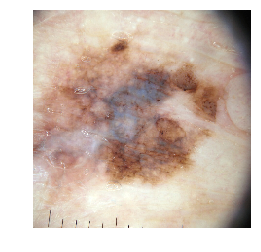


gt: True, pred: True, confidence: 94.033%


In [94]:
plt.imshow(the_image.astype(np.uint8), interpolation="nearest")
plt.axis("off")
plt.show()
print()
print("gt: {}, pred: {}, confidence: {:.3f}%".format(cor_label[0], the_pred[0], best_pred[0]*100))

Malignant:
	grnd_truth: True
	pred_class: True


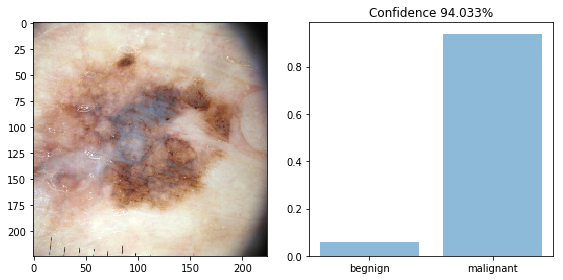

In [298]:
def display_figure_and_prob(img, conf, pred_malignant, gt_label):
    probs = [0, 0]
    y_pos = ['begnign', 'malignant']
    probs[1] = conf
    probs[0] = 1-conf
    max_conf = max(probs[0], probs[1])

    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    ax1.imshow(img.astype(np.uint8), interpolation="nearest")
    #y_pos = np.arange(2)
    print("Malignant:\n\tgrnd_truth: {}\n\tpred_class: {}".format(gt_label, pred_malignant))
    ax2.bar(y_pos, probs, align='center', alpha=0.5)
    plt.title("Confidence {:.3f}%".format(max_conf*100))
    plt.grid('off')
    plt.tight_layout()
    plt.show()
display_figure_and_prob(the_image, best_pred[0], the_pred[0], cor_label[0])

## How does the current architecture classify the image

test auc: 0.000% acc: 100.000% loss: 0.06152
true_class: [[ True]]
pred_class [[ True]]
confidence: 94.0332%
Malignant:
	grnd_truth: True
	pred_class: True


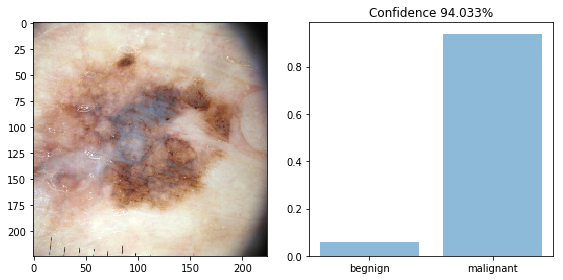

In [204]:
def test_model(img, label):
    reset_graph()
    data_params = create_hyper_params()
    g2 = build_graph(data_params)
    best_params = load_obj(BEST_PARAMS_PATH)
    with tf.Session(graph=g2) as sess:
        saver, init_global, init_local = g2.get_collection("save_init")
        X, y_raw, training_op = g2.get_collection("main_ops")
        preds, y_true_cls, y_pred_cls, _ = g2.get_collection("preds")
        test_auc, test_auc_update, test_acc, test_acc_update, test_acc_reset_op = g2.get_collection("test_metrics")
        test_mean_loss, test_mean_loss_update, test_loss_reset_op = g2.get_collection("test_loss")
        logz = g2.get_collection("logits")[0]

        sess.run([init_global, init_local])

        restore_model_params(model_params=best_params, g=g2, sess=sess)
        sess.run([test_acc_reset_op, test_loss_reset_op])
        Xb, yb = np.expand_dims(img,0), np.expand_dims(label, 0)
        batch_accuracy, batch_loss, batch_auc = sess.run([test_acc_update, test_mean_loss_update, test_auc_update], 
                                                                  feed_dict={X:Xb,y_raw:[yb]})
        pred_value, true_cls_value, pred_cls_value = sess.run([preds, y_true_cls, y_pred_cls],
                                                              feed_dict={X:Xb,y_raw:[yb]})
        logits_val = sess.run([logz], feed_dict={X:Xb,y_raw:[yb]})[0]
        print
        final_test_acc, final_test_loss, final_test_auc = sess.run([test_acc, test_mean_loss, test_auc])
        print("test auc: {:.3f}% acc: {:.3f}% loss: {:.5f}".format(final_test_auc*100, 
                                                                   final_test_acc*100,
                                                                   final_test_loss))
        pred_idx = pred_cls_value[0]
        print("true_class: {}\npred_class {}".format(true_cls_value, pred_cls_value))
        
        confidence = pred_value[0][pred_idx]*100
        print("confidence: {:.4f}%".format(confidence[0]))

        display_figure_and_prob(img=img, conf=pred_value[0][pred_idx][0], pred_malignant=pred_cls_value[0][0], gt_label=label)
        
    return pred_idx, confidence
        
pred_label, pred_confidence = test_model(the_image, cor_label[0])

In [280]:
def build_adv_graph(data_params):
    g = tf.Graph()
    n_outputs = 1
    IMG_HEIGHT = 224
    IMG_WIDTH = 224
    CHANNELS = 3
    with g.as_default():
        with tf.name_scope("inputs"):
            X = tf.placeholder(tf.float32, shape=[None, IMG_HEIGHT, IMG_WIDTH, CHANNELS], name="X") # Input
            Xx = tf.Variable(tf.zeros((IMG_HEIGHT, IMG_WIDTH, CHANNELS)))
            Xxx = tf.expand_dims(Xx, 0)
            #y = tf.placeholder(tf.float32, shape=(None, n_outputs), name="labels") # Target
            y_raw = tf.placeholder(tf.int64, shape=[None, n_outputs], name="y_input")
            y = tf.cast(y_raw, tf.float32, name="label")

        with tf.name_scope("cnn"):
            #224x224x3
            h_1 = tf.layers.conv2d(Xxx, filters=32, kernel_size=3, activation=tf.nn.relu,
                                   padding='SAME', strides=2, name="conv_1") # 112x112x3
            
            #112x112x32
            h_2 = tf.layers.conv2d(h_1, filters=64, kernel_size=3, activation=tf.nn.relu,
                                   padding='SAME', strides=2, name="conv_2") # 64x64x64
            
            #64x64x64
            h_3 = tf.layers.conv2d(h_2, filters=96, kernel_size=3, activation=tf.nn.elu,
                                   padding='SAME', strides=2, name="conv_3") # 32x32x96
            
            # 32x32x96
            h_4 = tf.layers.max_pooling2d(h_3, pool_size=[2,2],
                                          strides=2, name="max_pool_01") # 16x16x96
            
            # 16x16x96
            h_5 = tf.layers.conv2d(h_4, filters=128, kernel_size=3, activation=tf.nn.elu,
                                   padding='SAME', strides=1, name="conv_4") # 16x16x128
            
            # 16x16x128
            h_6 = tf.layers.conv2d(h_5, filters=192, kernel_size=3, activation=tf.nn.elu,
                                   padding='SAME', strides=1, name="conv_5") # 16x16x192
            
            # 16x16x192
            h_7 = tf.layers.max_pooling2d(h_6, pool_size=[2,2],
                                          strides=2, name="max_pool_02") # 8x8x192
            
            # 8x8x192
            h_8 = tf.layers.conv2d(h_7, filters=256, kernel_size=3, activation=tf.nn.elu,
                                   padding='SAME', strides=2, name="conv_6") # 4x4x256
            
            # 4x4x256
            h_9 = tf.layers.conv2d(h_8, filters=1024, kernel_size=4, activation=tf.nn.elu,
                                   padding='SAME', strides=1, name="conv_7") # 1x1x1024
            last_shape = int(np.prod(h_9.get_shape()[1:]))
            h_9_flat = tf.reshape(h_9, shape=[-1, last_shape]) # 1024
            
            # 1024
            h_10 = tf.layers.dense(h_9_flat, 256, name="layer_01", activation=tf.nn.elu)
            h_11 = tf.layers.dense(h_10, 64, name="layer_02", activation=tf.nn.elu)
            h_12 = tf.layers.dense(h_11, 16, name="layer_03", activation=tf.nn.elu)
            
            logits = tf.layers.dense(h_12, n_outputs, name="logits")
            preds = tf.sigmoid(logits, name="preds")

        with tf.name_scope("loss"):
            xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
            batch_loss = tf.reduce_mean(xentropy, name="loss")
        
        with tf.name_scope("train"):
            optimizer = tf.train.AdamOptimizer(learning_rate=data_params['init_lr'],
                                               beta1=0.9,
                                               beta2=0.999,
                                               epsilon=1e-08,
                                               use_locking=False,
                                               name='Adam')
            training_op = optimizer.minimize(batch_loss, name="training_op")
            
        with tf.name_scope("save_session"):
            init_global = tf.global_variables_initializer()
            init_local = tf.local_variables_initializer()
            saver = tf.train.Saver()
            
            
        with tf.name_scope("adv"):
            x = tf.placeholder(tf.float32, (IMG_HEIGHT, IMG_WIDTH, CHANNELS), name="jack") # Input
            x_hat = Xx
            assign_op = tf.assign(x_hat, x)

            y_hat = tf.placeholder(tf.int32, (None))
            labels = tf.cast(y_hat, tf.float32, name="label")
            #labels = tf.one_hot(y_hat, 10)
            #print("logits: {}".format(logits))
            #print("labels: {}".format(labels))
            loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels, name="adv_loss")
            adv_batch_loss = tf.reduce_mean(loss)
#             optimizerz = tf.train.AdamOptimizer(learning_rate=1e-3,
#                                                beta1=0.9,
#                                                beta2=0.999,
#                                                epsilon=1e-08,
#                                                use_locking=False,
#                                                name='Adam')
#             optim_step = optimizerz.minimize(adv_batch_loss, var_list=[Xx])
            optim_step = tf.train.GradientDescentOptimizer(3).minimize(adv_batch_loss, var_list=[Xx])
            
            epsilon = tf.placeholder(tf.float32, ())
            below = x - epsilon
            above = x + epsilon
            projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 255)

            with tf.control_dependencies([projected]):
                project_step = tf.assign(x_hat, projected)
                
            for node in (assign_op, x, optim_step, loss, y_hat, epsilon, x_hat, project_step):
                g.add_to_collection("adv", node)

        # Ops: training metrics
        with tf.name_scope("metrics"):
            # ================================== performance
            with tf.name_scope("common"):
                #preds = tf.nn.softmax(logits, name="prediction")
                #y_true_cls = tf.argmax(y,1)
                #y_pred_cls = tf.argmax(preds,1)
                y_true_cls = tf.greater_equal(y, 0.5)
                y_pred_cls = tf.greater_equal(preds, 0.5)

                correct_prediction = tf.equal(y_pred_cls, y_true_cls, name="correct_predictions")
                batch_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            with tf.name_scope("train_metrics") as scope:
                train_auc, train_auc_update = tf.metrics.auc(labels=y, predictions=preds)
                train_acc, train_acc_update = tf.metrics.accuracy(labels=y_true_cls, predictions=y_pred_cls)
                train_acc_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                train_met_reset_op = tf.variables_initializer(train_acc_vars, name="train_met_reset_op")
            with tf.name_scope("val_metrics") as scope:
                val_auc, val_auc_update = tf.metrics.auc(labels=y, predictions=preds)
                val_acc, val_acc_update = tf.metrics.accuracy(labels=y_true_cls, predictions=y_pred_cls)
                val_acc_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                val_met_reset_op = tf.variables_initializer(val_acc_vars, name="val_met_reset_op")
            with tf.name_scope("test_metrics") as scope:
                test_auc, test_auc_update = tf.metrics.auc(labels=y, predictions=preds)
                test_acc, test_acc_update = tf.metrics.accuracy(labels=y_true_cls, predictions=y_pred_cls)
                test_acc_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                test_acc_reset_op = tf.variables_initializer(test_acc_vars, name="test_met_reset_op")

            # =============================================== loss 
            with tf.name_scope("train_loss_eval") as scope:
                train_mean_loss, train_mean_loss_update = tf.metrics.mean(batch_loss)
                train_loss_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                train_loss_reset_op = tf.variables_initializer(train_loss_vars, name="train_loss_reset_op")
            with tf.name_scope("val_loss_eval") as scope:
                val_mean_loss, val_mean_loss_update = tf.metrics.mean(batch_loss)
                val_loss_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                val_loss_reset_op = tf.variables_initializer(val_loss_vars, name="val_loss_reset_op")
            with tf.name_scope("test_loss_eval")as scope:
                test_mean_loss, test_mean_loss_update = tf.metrics.mean(batch_loss)
                test_loss_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                test_loss_reset_op = tf.variables_initializer(test_loss_vars, name="test_loss_rest_op")

        # --- create collections
        for node in (saver, init_global, init_local):
            g.add_to_collection("save_init", node)
        for node in (X, Xx, y, training_op):
            g.add_to_collection("main_ops", node)
        for node in (preds, y_true_cls, y_pred_cls, correct_prediction):
            g.add_to_collection("preds", node)
        for node in (train_auc, train_auc_update, train_acc, train_acc_update, train_met_reset_op):
            g.add_to_collection("train_metrics", node)
        for node in (val_auc, val_auc_update, val_acc, val_acc_update, val_met_reset_op):
            g.add_to_collection("val_metrics", node)
        for node in (test_auc, test_auc_update, test_acc, test_acc_update, test_acc_reset_op):
            g.add_to_collection("test_metrics", node)
        for node in (train_mean_loss, train_mean_loss_update, train_loss_reset_op):
            g.add_to_collection("train_loss", node)
        for node in (val_mean_loss, val_mean_loss_update, val_loss_reset_op):
            g.add_to_collection("val_loss", node)
        for node in (test_mean_loss, test_mean_loss_update, test_loss_reset_op):
            g.add_to_collection("test_loss", node)
        g.add_to_collection("logits", logits)
            
        # ===================================== tensorboard
        with tf.name_scope("tensorboard_writer") as scope:
            epoch_train_loss_scalar = tf.summary.scalar('train_epoch_loss', train_mean_loss)
            epoch_train_acc_scalar = tf.summary.scalar('train_epoch_acc', train_acc)
            epoch_train_auc_scalar = tf.summary.scalar('train_epoch_auc', train_auc)
            epoch_train_write_op = tf.summary.merge([epoch_train_loss_scalar, epoch_train_acc_scalar, epoch_train_auc_scalar], name="epoch_train_write_op")

            # ===== epoch, validation
            epoch_validation_loss_scalar = tf.summary.scalar('validation_epoch_loss', val_mean_loss)
            epoch_validation_acc_scalar = tf.summary.scalar('validation_epoch_acc', val_acc)
            epoch_validation_auc_scalar = tf.summary.scalar('validation_epoch_auc', val_auc)
            epoch_validation_write_op = tf.summary.merge([epoch_validation_loss_scalar, epoch_validation_acc_scalar, epoch_validation_auc_scalar], name="epoch_validation_write_op")
        
        for node in (epoch_train_write_op, epoch_validation_write_op):
            g.add_to_collection("tensorboard", node)
            
    return g

In [283]:
def produce_targeted_adv_image(img, adv_target=1, adv_eps=20, adv_lr=1e-1,adv_steps=20000):
    #img = (np.asarray(img) / 255.0).astype(np.float32)
    #TODO: learning rate is currently hardcoded
    reset_graph()
    data_params = create_hyper_params()
    g3 = build_adv_graph(data_params)
    best_params = load_obj(BEST_PARAMS_PATH)
    with tf.Session(graph=g3) as sess:
        saver, init_global, init_local = g3.get_collection("save_init")
        X, Xx, y, training_op = g3.get_collection("main_ops")
        preds, y_true_cls, y_pred_cls, _ = g3.get_collection("preds")
        test_auc, test_auc_update, test_acc, test_acc_update, test_acc_reset_op = g3.get_collection("test_metrics")
        test_mean_loss, test_mean_loss_update, test_loss_reset_op = g3.get_collection("test_loss")
        logz = g3.get_collection("logits")[0]

        sess.run([init_global, init_local])

        restore_model_params(model_params=best_params, g=g3, sess=sess)
        sess.run([test_acc_reset_op, test_loss_reset_op])
        

        # execution
        assign_op, x, optim_step, loss, y_hat, epsilon, x_hat, project_step = g3.get_collection("adv")

        # initialization step
        sess.run(assign_op, feed_dict={x: img})

        #print("adv_target: {}".format(adv_target.shape))
        # projected gradient descent
        #adv_target = np.expand_dims(adv_steps, 0)
        for i in tqdm(range(1, adv_steps+1)):
            # gradient descent step
            _, loss_value = sess.run(
                [optim_step, loss],
                feed_dict={y_hat: [adv_target]})
            # project step
            sess.run(project_step, feed_dict={x: img, epsilon: adv_eps})
            if (i+1) % 1000 == 0:
                print('step %d, loss=%g' % (i+1, loss_value))

        adv_out = x_hat.eval() # retrieve the adversarial example
        
    return adv_out
#the_image, best_pred[0], the_pred[0], cor_label[0]
adv_out = produce_targeted_adv_image(the_image, adv_target=0)
#adv_flat = adv_out.reshape((784))


  0%|          | 0/20000 [00:00<?, ?it/s]
Exception in thread Thread-85:
Traceback (most recent call last):
  File "/home/jack/anaconda3/envs/tf_edge/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/jack/anaconda3/envs/tf_edge/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jack/anaconda3/envs/tf_edge/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  5%|▌         | 1009/20000 [00:10<03:17, 96.16it/s]

step 1000, loss=1.29921


 10%|█         | 2010/20000 [00:20<03:07, 96.12it/s]

step 2000, loss=0.658074


 15%|█▌        | 3008/20000 [00:31<02:56, 96.14it/s]

step 3000, loss=0.421112


 20%|██        | 4015/20000 [00:41<02:46, 96.14it/s]

step 4000, loss=0.314026


 25%|██▌       | 5014/20000 [00:52<02:36, 95.98it/s]

step 5000, loss=0.252885


 30%|███       | 6013/20000 [01:02<02:25, 95.96it/s]

step 6000, loss=0.213347


 35%|███▌      | 7010/20000 [01:13<02:15, 95.95it/s]

step 7000, loss=0.185615


 40%|████      | 8014/20000 [01:23<02:04, 96.01it/s]

step 8000, loss=0.164964


 45%|████▌     | 9012/20000 [01:33<01:54, 96.05it/s]

step 9000, loss=0.148873


 50%|█████     | 10017/20000 [01:44<01:43, 96.08it/s]

step 10000, loss=0.135995


 55%|█████▌    | 11012/20000 [01:54<01:33, 96.10it/s]

step 11000, loss=0.125416


 60%|██████    | 12014/20000 [02:05<01:23, 96.02it/s]

step 12000, loss=0.116566


 65%|██████▌   | 13015/20000 [02:15<01:12, 95.97it/s]

step 13000, loss=0.109057


 70%|███████   | 14014/20000 [02:25<01:02, 96.00it/s]

step 14000, loss=0.102597


 75%|███████▌  | 15017/20000 [02:36<00:51, 95.99it/s]

step 15000, loss=0.0969679


 80%|████████  | 16009/20000 [02:46<00:41, 95.97it/s]

step 16000, loss=0.0919941


 85%|████████▌ | 17012/20000 [02:57<00:31, 95.92it/s]

step 17000, loss=0.0875775


 90%|█████████ | 18010/20000 [03:07<00:20, 95.83it/s]

step 18000, loss=0.0836283


 95%|█████████▌| 19009/20000 [03:18<00:10, 95.82it/s]

step 19000, loss=0.0800734


100%|██████████| 20000/20000 [03:28<00:00, 95.81it/s]


step 20000, loss=0.0768611


In [292]:
# print(adv_out.shape)
# print(the_image[0][0])
print(adv_out.shape)

(224, 224, 3)


test auc: 0.000% acc: 0.000% loss: 2.60402
true_class: [[ True]]
pred_class [[False]]
Malignant:
	grnd_truth: True
	pred_class: False


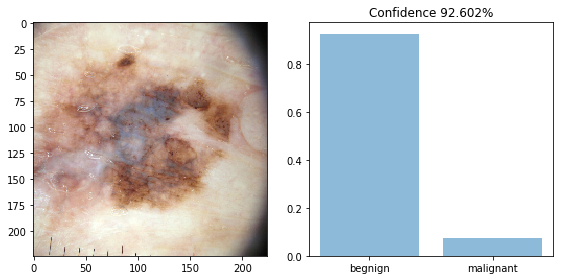

In [299]:
def test_adversarial(img, label):
    reset_graph()
    data_params = create_hyper_params()
    g2 = build_graph(data_params)
    best_params = load_obj(BEST_PARAMS_PATH)
    with tf.Session(graph=g2) as sess:
        saver, init_global, init_local = g2.get_collection("save_init")
        X, y_raw, training_op = g2.get_collection("main_ops")
        preds, y_true_cls, y_pred_cls, correct_prediction = g2.get_collection("preds")
        test_auc, test_auc_update, test_acc, test_acc_update, test_acc_reset_op = g2.get_collection("test_metrics")
        test_mean_loss, test_mean_loss_update, test_loss_reset_op = g2.get_collection("test_loss")
        logz = g2.get_collection("logits")[0]

        sess.run([init_global, init_local])

        restore_model_params(model_params=best_params, g=g2, sess=sess)
        sess.run([test_acc_reset_op, test_loss_reset_op])
        Xb, yb = np.expand_dims(img,0), np.expand_dims(label, 0)
        batch_accuracy, batch_loss, batch_auc = sess.run([test_acc_update, test_mean_loss_update, test_auc_update], 
                                                                  feed_dict={X:Xb,y_raw:[yb]})
        pred_value, true_cls_value, pred_cls_value = sess.run([preds, y_true_cls, y_pred_cls],
                                                              feed_dict={X:Xb,y_raw:[yb]})
        logits_val = sess.run([logz], feed_dict={X:Xb,y_raw:[yb]})[0]

        final_test_acc, final_test_loss, final_test_auc = sess.run([test_acc, test_mean_loss, test_auc])
        print("test auc: {:.3f}% acc: {:.3f}% loss: {:.5f}".format(final_test_auc*100, 
                                                                   final_test_acc*100,
                                                                   final_test_loss))
        print("true_class: {}\npred_class {}".format(true_cls_value, pred_cls_value))
        #print(pred_value[0][0])
        #confidence = pred_value[0][pred_idx][0]

        confidence = pred_value[0][0]
        display_figure_and_prob(img=img, conf=confidence, pred_malignant=pred_cls_value[0][0], gt_label=label)
        #display_figure_and_prob(adv.reshape(28, 28), pred_value[0])

    return pred_cls_value[0][0], confidence

a_pred_label, a_pred_confidence = test_adversarial(adv_out, cor_label[0])

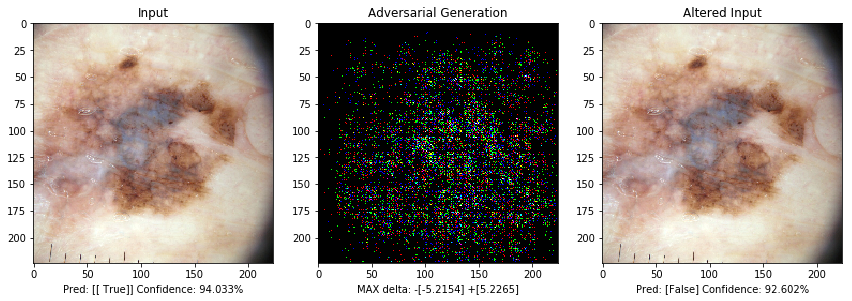

In [300]:
def plot_adv_array(img, adv, pred_label, pred_confidence, 
                   a_pred_label, a_pred_confidence):
    diff = adv - img
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    ax1.imshow(img.astype(np.uint8), interpolation="nearest")
    #cmapx = plt.get_cmap('bwr')
    ax1.set_title("Input")
    ax1.set_xlabel("Pred: [{}] Confidence: {:.3f}%".format(pred_label, pred_confidence[0]))
    ax2.imshow(diff.astype(np.uint8), interpolation="nearest")
    
    # TODO: THIS VISUALIZATION IS POOR
    # converting to uint8 is likely not the way to appoach this
    # likely will want to grab each channel, which may be interesting in iteself
    ax2.set_title("Adversarial Generation")
    ax2.set_xlabel("MAX delta: -[{:.4f}] +[{:.4f}]".format(np.min(diff), np.max(diff)))
    
    ax3.imshow(adv.astype(np.uint8), interpolation="nearest")
    ax3.set_title("Altered Input")
    if a_pred_label:
        a_conf = a_pred_confidence
    else:
        a_conf = 1 - a_pred_confidence
    ax3.set_xlabel("Pred: [{}] Confidence: {:.3f}%".format(a_pred_label, a_conf*100))
    plt.grid('off')
    plt.tight_layout()
    plt.show()

plot_adv_array(the_image, adv_out, pred_label, pred_confidence, a_pred_label, a_pred_confidence)

In [307]:
diff = adv_out - the_image
# plt.imshow(diff.astype(np.uint8), cmap=plt.get_cmap('bwr'), interpolation="nearest")
# plt.grid('off')
# plt.tight_layout()
# plt.show()
print(diff.shape)
print(diff[0].shape)
print(diff[:][0].shape)
print(diff[:][:][0].shape)
print(diff[:][0][:].shape)

(224, 224, 3)
(224, 3)
(224, 3)
(224, 3)
(224, 3)
